# Exploration 16. SRGAN 활용하기

### 프로젝트 1. 직접 고른 이미지로 SRGAN 실험하기

#### 프로젝트 1-1 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

##### 1. 높은 해상도를 가진 이미지를 가져온다.

(503, 680, 3)


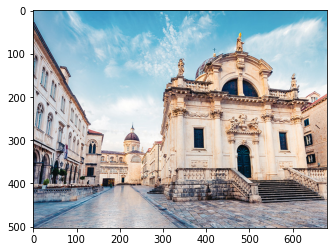

In [2]:
# 이미지 불러오기
hd_img_path = os.getenv('HOME')+'/aiffel/super_resolution/background.jpg'
hd_img = cv2.imread(hd_img_path)

print(hd_img.shape)
plt.imshow(cv2.cvtColor(hd_img,cv2.COLOR_BGR2RGB))

##### 2. bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.

(125, 170, 3)


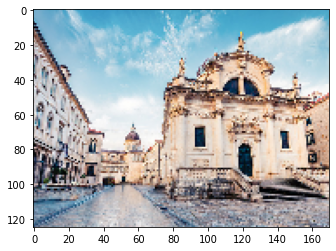

In [3]:
y, x = int(hd_img.shape[0]*0.25), int(hd_img.shape[1]*0.25)
input_img = cv2.resize(
    hd_img,
    dsize=(x,y),
    interpolation=cv2.INTER_CUBIC)    # bicubic 설정

# 시각화
print(input_img.shape)
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))

##### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

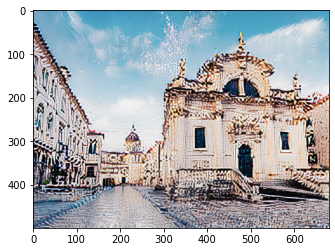

In [4]:
# 이미 학습된 모델 불러오기
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

# SRGAN의 고해상도 이미지 생성하기
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_img = apply_srgan(input_img)
plt.imshow(cv2.cvtColor(srgan_img, cv2.COLOR_BGR2RGB))

##### 4. 2의 이미지에 bicubic interpolation 적용하여 4배로 늘린다.

(503, 680, 3)


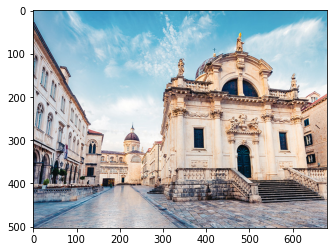

In [5]:
bicubic_img = cv2.resize(
    hd_img,
    dsize=(hd_img.shape[1],hd_img.shape[0]),
    interpolation=cv2.INTER_CUBIC)    # bicubic 설정

# 시각화
print(bicubic_img.shape)
plt.imshow(cv2.cvtColor(bicubic_img, cv2.COLOR_BGR2RGB))

##### 5. 3개의 이미지를 나란히 시각화한다.

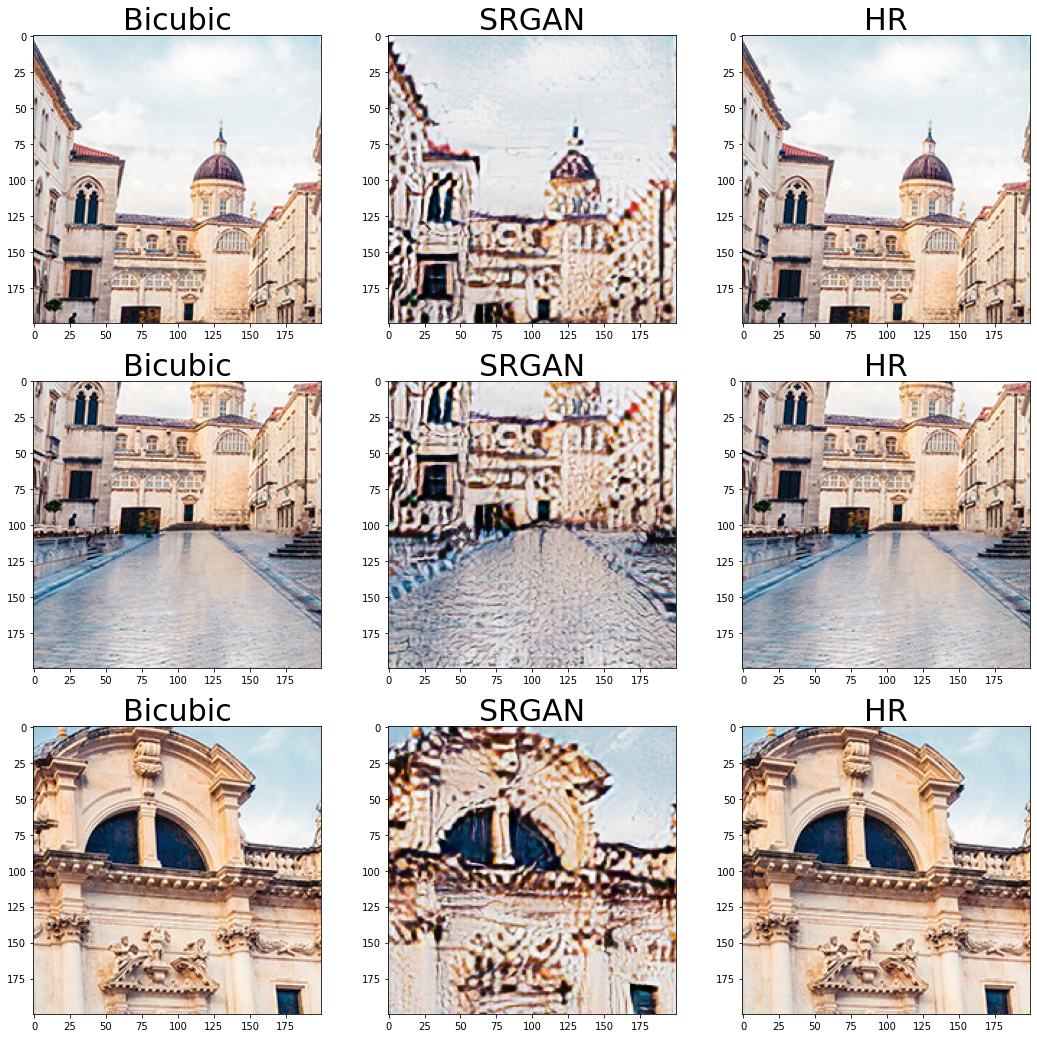

In [6]:
# 이미지의 특정 부분을 잘라내는 함수
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

left_tops = [(200,100), (300,100), (100,400)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_img, left_top, 200, 200)
    img2 = crop(srgan_img, left_top, 200, 200)
    img3 = crop(hd_img, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i], fontsize=30)

##### 6. 결과
- SRGAN의 화질이 더 좋을 것이라는 예상과 달리 뭔가 좀 선명하지 않고 울퉁불퉁한 모습이 있다. 고해상도 사진이라 별 큰 차이를 못 느끼겠다.

### 프로젝트 1-2

##### 1. 낮은 해상도 이미지를 가져온다.

(746, 560, 3)


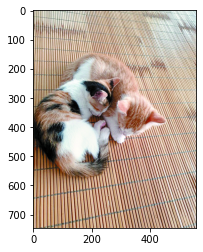

In [7]:
# 이미지 불러오기
cat_img_path = os.getenv('HOME')+'/aiffel/super_resolution/cute.jpg'
cat_img = cv2.imread(cat_img_path)

print(cat_img.shape)
plt.imshow(cv2.cvtColor(cat_img,cv2.COLOR_BGR2RGB))

##### 2. SRGAN을 이용해 고해상도 이미지를 생성한다.

(2984, 2240, 3)


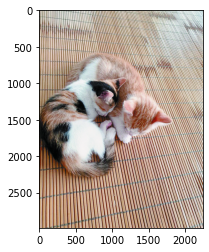

In [8]:
srgan_img2 = apply_srgan(cat_img)

# 시각화
print(srgan_img2.shape)
plt.imshow(cv2.cvtColor(srgan_img2, cv2.COLOR_BGR2RGB))

##### 3. bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

(2984, 2240, 3)


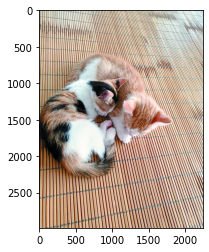

In [9]:
bicubic_img2 = cv2.resize(
    cat_img,
    dsize=(cat_img.shape[1]*4, cat_img.shape[0]*4),
    interpolation=cv2.INTER_CUBIC)    # bicubic 설정

# 시각화
print(bicubic_img2.shape)
plt.imshow(cv2.cvtColor(bicubic_img2, cv2.COLOR_BGR2RGB))

##### 4. 2개 이미지를 나란히 시각화 한다.

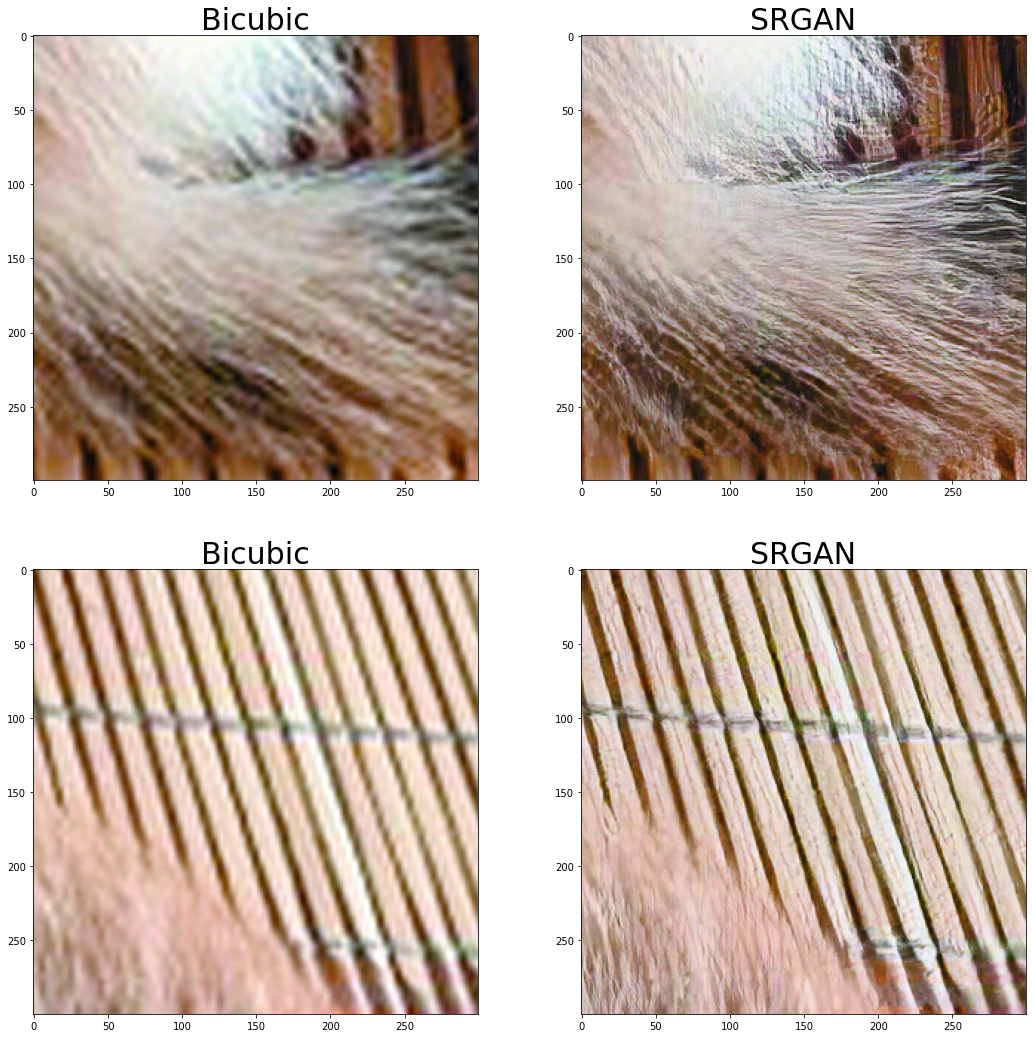

In [10]:
# 이미지의 특정 부분을 잘라내는 함수
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

left_tops = [(2000,500), (500,1100)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_img2, left_top, 300, 300)
    img2 = crop(srgan_img2, left_top, 300, 300)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(4):
    plt.subplot(2,2,i+1) 
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i], fontsize=30)

##### 5. 결과
- 위의 고해상도 사진과 달리 저해상도 사진을 넣고 적용하니 확실히 SRGAN의 화질이 더 선명한 것을 눈으로 식별할 수 있었다.

### 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

##### 2-1. gif 파일 불러오기

In [11]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME') + '/aiffel/super_resolution/'
gif = cv2.VideoCapture(gif_path + 'book_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        
print("frame수 : ", len(frames))
print("frame 크기 : ", (frames[0].shape))

frame수 :  22
frame 크기 :  (215, 380, 3)


##### 2-2. 프레임별 Super Resolution 진행하기
> * Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. <br>
> * Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어봅시다.

In [12]:
# Bicubic interpolation을 이용해 가로, 세로 픽셀 수를 4배로 늘려보자.
bicubic_frames = [cv2.resize(
    frame,
    dsize=(frame.shape[1]*4, frame.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
) for frame in frames]
bicubic_frames[0].shape    

(860, 1520, 3)

In [13]:
# SRGAN을 이용하여 가로, 세로 픽셀 수를 4배로 늘려보자.
srgan_frames = [apply_srgan(frame) for frame in frames]
srgan_frames[0].shape

(860, 1520, 3)

##### 2-3. 프레임을 합쳐 gif 만들기

In [14]:
import imageio

imageio.mimsave(gif_path + "Bicubic_frames.gif", bicubic_frames)
imageio.mimsave(gif_path + "SRGAN_frames.gif", srgan_frames)

##### 2-4. Jupyter notebook에 gif 표시하기

In [16]:
from IPython.display import Image as show_gif

# show_gif(filename=(gif_path + "book_lr.gif"), width=500)

In [17]:
# show_gif(filename=(gif_path + "Bicubic_frames.gif"), width=500)

In [18]:
# show_gif(filename=(gif_path + "SRGAN_frames.gif").width=500)

Bicubic_frames.gif : https://drive.google.com/file/d/1cqB_3CJV_CeSxL8h9H_QCZLQIAOA_Uhf/view?usp=sharing

SRGAN_frames.gif : https://drive.google.com/file/d/1-dIn3BzUaejeHjYEhhN2Ft_VH9GEMxEc/view?usp=sharing

# 회고
> * 위의 gif파일도 육안으로는 별 차이를 못느끼겠다. <br> 
> * 저해상도의 이미지를 고해상도로 만드는 모델들이 어떠한 원리를 가지고 이미지를 만드는지 잘 이해는 가지 않지만 눈으로 변화를 볼 수 있어서 신기했다.<br>
> * 아직도 좌표의 개념이 잘 안잡혀 있어서 더 공부해야겠다는 생각을 했다.